In [1]:
#import decision regression tools:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text
import plotly.express as px
import config

In [2]:
# create database engine
db_url = f"postgresql://{config.DB_USERNAME}:{config.DB_PASSWORD}@{config.DB_HOST}/{config.DB_NAME}"
engine = create_engine(db_url)

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# load all the data into a datafame by joining the tables
query = text('''
Select * 
FROM "RawRecords" as r
JOIN "CalculatedStats" AS cs ON cs."RecordId"=r."Id";
''')
df = pd.read_sql_query(query,con=engine)
df.set_index('Id', inplace=True)
df

,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath4Score,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,223.0,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,233.0,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,229.0,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,229.0,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,227.0,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015_VIRGINIA,VIRGINIA,2015,1279867.0,15857524.0,1012205.0,6240349.0,8604970.0,16113212.0,8755896.0,5075509.0,...,247.0,288.0,229.0,267.0,2015_VIRGINIA,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,WASHINGTON,2015,1072359.0,13709442.0,1036422.0,8293812.0,4379208.0,13630138.0,6508964.0,4510672.0,...,245.0,287.0,226.0,267.0,2015_WASHINGTON,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,WEST_VIRGINIA,2015,279565.0,3478401.0,362959.0,1979466.0,1135976.0,3466981.0,1819903.0,1161944.0,...,235.0,271.0,216.0,260.0,2015_WEST_VIRGINIA,0.104347,0.569074,0.326580,12.442191,0.523201


## Tweaking Database

In [4]:
model_df = df[[
    "FederalFundingPercent",
    "StateFundingPercent",
    "LocalFundingPercent",
    "RevenuePerStudent",
    "InstructionalExpensePercent"
]]
model_df.index = df.index
model_df

,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent
Id,,,,,
2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164
2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451
2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467
2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684
2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209
...,...,...,...,...,...
2015_VIRGINIA,0.063831,0.393526,0.542643,12.389978,0.552160
2015_WASHINGTON,0.075599,0.604971,0.319430,12.784377,0.474780
2015_WEST_VIRGINIA,0.104347,0.569074,0.326580,12.442191,0.523201


In [5]:
#dropping DISTRICT_OF_COLUMBIA data
df = df.loc[df['State'] != 'DISTRICT_OF_COLUMBIA']
df.shape

(350, 22)

In [6]:
# combining grade scores
Avg_Score = (df.AvgMath4Score + df.AvgMath8Score + df.AvgReading4Score + df.AvgReading8Score)/4
df['Avg Score'] = Avg_Score
df.head()

/Users/ericdally/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,Year,Enrolled,TotalRevenue,FederalRevenue,StateRevenue,LocalRevenue,TotalExpenditure,InstructionExpenditure,SupportServicesExpenditure,...,AvgMath8Score,AvgReading4Score,AvgReading8Score,RecordId,FederalFundingPercent,StateFundingPercent,LocalFundingPercent,RevenuePerStudent,InstructionalExpensePercent,Avg Score
Id,,,,,,,,,,,,,,,,,,,,,
2003_ALABAMA,ALABAMA,2003,727900.0,5196054.0,567704.0,2966981.0,1661369.0,5298932.0,2817111.0,1521462.0,...,262.0,207.0,253.0,2003_ALABAMA,0.109257,0.571007,0.319737,7.138417,0.542164,236.25
2003_ALASKA,ALASKA,2003,133303.0,1425948.0,259423.0,813371.0,353154.0,1610289.0,763525.0,514052.0,...,279.0,212.0,256.0,2003_ALASKA,0.181930,0.570407,0.247663,10.697044,0.535451,245.00
2003_ARIZONA,ARIZONA,2003,875111.0,6529894.0,740579.0,2912629.0,2876686.0,6210287.0,2810907.0,1964229.0,...,271.0,209.0,255.0,2003_ARIZONA,0.113414,0.446045,0.440541,7.461789,0.430467,241.00
2003_ARKANSAS,ARKANSAS,2003,450158.0,3241275.0,379947.0,2394336.0,466992.0,3242799.0,1768713.0,972598.0,...,266.0,214.0,258.0,2003_ARKANSAS,0.117221,0.738702,0.144077,7.200305,0.545684,241.75
2003_CALIFORNIA,CALIFORNIA,2003,6226552.0,59815855.0,5795655.0,33617766.0,20402434.0,59749885.0,29561563.0,17030335.0,...,267.0,206.0,251.0,2003_CALIFORNIA,0.096892,0.562021,0.341087,9.606578,0.494209,237.75


## Checking Normality

(array([10., 17., 25., 43., 42., 77., 80., 39., 11.,  6.]),
 array([235.25 , 238.325, 241.4  , 244.475, 247.55 , 250.625, 253.7  ,
        256.775, 259.85 , 262.925, 266.   ]),
 <BarContainer object of 10 artists>)

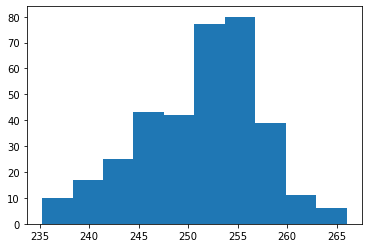

In [7]:
# Checking Distribution of Y variable
plt.hist(df['Avg Score'])

### Shapiro-Wilks Test

In [8]:
from scipy.stats import shapiro

stat, pvalue = shapiro(df['Avg Score'])
print(f'Statistics = {stat}, pvalue = {pvalue}')

#interpret Results
alpha =0.05
if pvalue > alpha:
    print('Sample looks normally distributed (fail to reject null hypothesis)')
else:
    print('Sample does not look normally distributed (reject null hypothesis)')

Statistics = 0.9784842133522034, pvalue = 4.348645597929135e-05
Sample does not look normally distributed (reject null hypothesis)


# Multiple Linear Regression

In [9]:
# Defining variables
X = df[[
    "FederalFundingPercent",
    "StateFundingPercent",
    "LocalFundingPercent",
    "RevenuePerStudent",
    "InstructionalExpensePercent"]]
y = df['Avg Score']

In [10]:
#Creating regression object
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [11]:
#Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [12]:
y_prediction =  regr.predict(X_test)

In [13]:
#Comparing the Test Set with Predicted Values
df_MR = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_prediction})
df_MR.head()

,Real Values,Predicted Values
Id,,
2011_CONNECTICUT,257.75,258.121334
2009_FLORIDA,252.75,252.023297
2009_OHIO,256.00,254.153142
2005_LOUISIANA,240.00,247.211981
2003_MAINE,253.00,253.399514


In [14]:
#Evaluating Regression Model
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)

print(f'R2 Value is {r2}, Means Squared Error is {mse}')

R2 Value is 0.48886869450429626, Means Squared Error is 19.679963480487494


In [15]:
#Finding Errors
df_MR_error_percentage = abs(df_MR['Real Values'] - df_MR['Predicted Values'])
df_MR_error_percentage.describe()

count    105.000000
mean       3.555025
std        2.666359
min        0.029492
25%        1.279742
50%        3.297251
75%        5.416121
max       10.932570
dtype: float64

(array([24., 18., 11., 17.,  9.,  8.,  9.,  5.,  3.,  1.]),
 array([ 0.0294916 ,  1.1197994 ,  2.2101072 ,  3.30041501,  4.39072281,
         5.48103061,  6.57133841,  7.66164622,  8.75195402,  9.84226182,
        10.93256962]),
 <BarContainer object of 10 artists>)

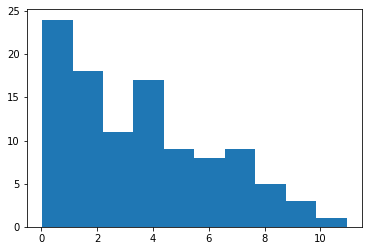

In [16]:
# Checking Normality of Errors
plt.hist(df_MR_error_percentage)

In [17]:
# Shapiro-Wilks test

from scipy.stats import shapiro

stat, pvalue = shapiro(df_MR_error_percentage)
print(f'Statistics = {stat}, pvalue = {pvalue}')

#interpret Results
alpha =0.05
if pvalue > alpha:
    print('Sample looks normally distributed (fail to reject null hypothesis)')
else:
    print('Sample does not look normally distributed (reject null hypothesis)')

Statistics = 0.9372237324714661, pvalue = 8.821523806545883e-05
Sample does not look normally distributed (reject null hypothesis)


In [18]:
#Finding the y intercept
print(regr.intercept_)

193.5384020064419


Feature: 0, Score: 48.09553
Feature: 1, Score: 60.60848
Feature: 2, Score: 0.54310
Feature: 3, Score: 5.39635


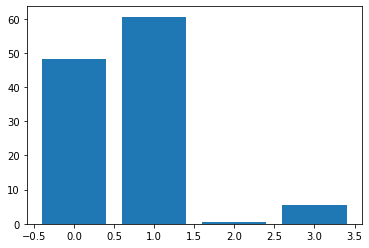

In [19]:
importance = regr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Building Model to predict scores for 2015

In [20]:
df['Year'].max()

2015

In [21]:
df_No_2015 = df.loc[df['Year'] != 2015]
df_No_2015.shape

(300, 23)